In [12]:
%matplotlib inline

from typing import List
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import pyarrow.csv as pv
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mutual_info_score
from collections import defaultdict

sns.set_theme()

In [13]:

df = pd.read_parquet('s3://datasets/kaggle/CooperUnion/cardataset/data.parquet', storage_options={
    'profile': 'local',
    'client_kwargs': {
        'endpoint_url': 'http://192.168.46.220:9000'
    }
})
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


## 1. Cleaning the data, basic
- use lower case to string type
- replace space with underscore `_`

In [14]:
# column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [15]:
# column values
obj_columns = df.dtypes[df.dtypes == 'object'].index
df[obj_columns]= df[obj_columns].apply(lambda series: series.str.lower().str.replace(' ', '_'))

In [16]:
df['number_of_doors'] = df['number_of_doors'].fillna(0).astype('int')

In [17]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2,luxury,compact,convertible,28,18,3916,34500


## 2. Exploratory data analysis
- data types
- unique counts
- null counts
- distribution

In [18]:
def df_info2(df):
    df_info = pd.DataFrame()
    df_info['dtype'] = df.dtypes
    df_info['#'] = df.count()
    df_info['#na'] = df.isna().sum()
    df_info['#unique'] = df.nunique()
    return df_info

In [19]:
df_dummies = df['market_category'].str.get_dummies(',').add_prefix('market_category_')

In [20]:
df = pd.concat([df.drop('market_category', axis=1), df_dummies], axis=1)

In [21]:
df_info2(df)

,dtype,#,#na,#unique
make,object,11914,0,48
model,object,11914,0,914
year,int64,11914,0,28
engine_fuel_type,object,11911,3,10
engine_hp,float64,11845,69,356
engine_cylinders,float64,11884,30,9
transmission_type,object,11914,0,5
driven_wheels,object,11914,0,4
number_of_doors,int64,11914,0,4
vehicle_size,object,11914,0,3


numerical types correlations

just check the last row or column, popularity looks like an irrevelant feature.

<AxesSubplot:>

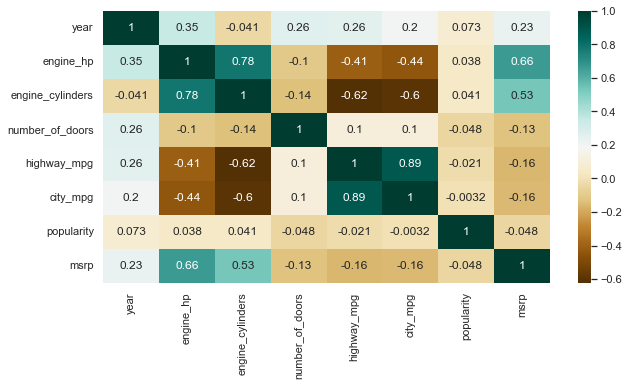

In [37]:
plt.figure(figsize=(10, 5))
sns.heatmap(df[['year', 'engine_hp', 'engine_cylinders', 'number_of_doors', 'highway_mpg', 'city_mpg', 'popularity', 'msrp']].corr(), cmap='BrBG', annot=True)

check categorical type importance.

<AxesSubplot:>

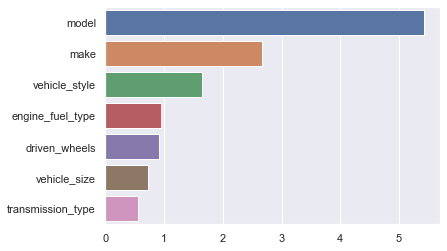

In [39]:
df.engine_fuel_type = df.engine_fuel_type.fillna('')
mi = df[['make', 'model', 'transmission_type', 'vehicle_size', 'vehicle_style', 'driven_wheels', 'engine_fuel_type']].apply(lambda series: mutual_info_score(series, df['msrp'])).sort_values(ascending=False)
sns.barplot(x=mi, y=mi.index)

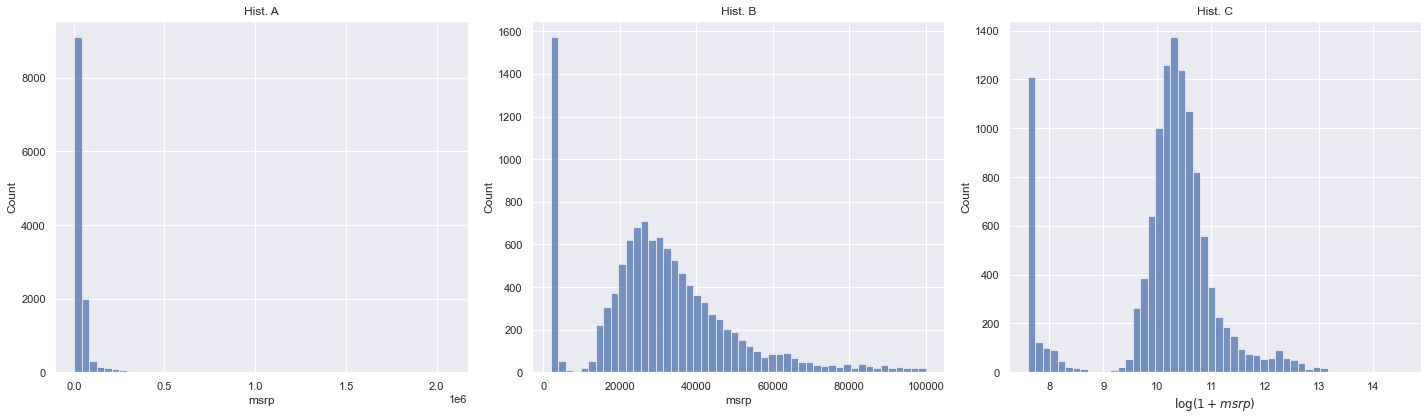

In [92]:
f, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.histplot(df.msrp, bins=50, ax=axs[0]);
axs[0].set_title('Hist. A')
## zoom in
sns.histplot(df.msrp[df.msrp <= 100000], bins=50, ax=axs[1]);
axs[1].set_title('Hist. B')
# sns.histplot(np.log(df.msrp + 1), bins=50)
sns.histplot(np.log1p(df.msrp), bins=50, ax=axs[2]); # shorcut function
axs[2].set_title('Hist. C')
axs[2].set_xlabel('$\log(1+msrp)$')
f.tight_layout()

the leftmost bar is so high is because there's minimum price in the website.

Hist. A there's a long tail on the right side.

Hist. B we zoom in to $<=100,000$

Hist. C we apply log on it, the center part looks more like a normal distribution, 

we can apply log to make the distribution more like a normal distribution.

## 3. Setting up the validation framework
- 60% for training
- 20% for validation
- 20% for testing

In [93]:
df_X = df.loc[:, df.columns != 'msrp']
y = np.log1p(df['msrp'].values)

In [94]:
df_train, df_test, y_train, y_test = train_test_split(df_X, y, test_size=0.4, random_state=42, shuffle=True)
df_val, df_test, y_val, y_test = train_test_split(df_test, y_test, test_size=0.5, shuffle=False)

## Baseline model

A simple model that acts as a reference in a ML project

In [95]:
# dataframe for all model
df_metrics = pd.DataFrame(columns = ['rmse_train', 'rmse_val', 'rmse_test'])

In [96]:
df_metrics.loc['base'] = np.nan

In [97]:
base = [
    'popularity', 'city_mpg', 'highway_mpg', 'engine_cylinders', 'engine_hp', 'number_of_doors'
]
df_info2(df_train[base])

,dtype,#,#na,#unique
popularity,int64,7148,0,48
city_mpg,int64,7148,0,62
highway_mpg,int64,7148,0,56
engine_cylinders,float64,7130,18,9
engine_hp,float64,7111,37,341
number_of_doors,int64,7148,0,4


In [98]:
X_train = df_train[base].fillna(0).values

In [99]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [100]:
y_hat = model.predict(X_train)

<AxesSubplot:ylabel='Count'>

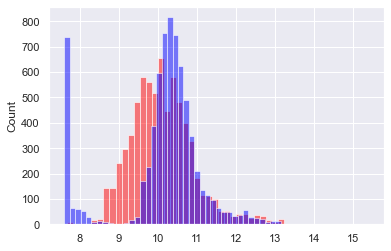

In [101]:
sns.histplot(y_hat, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

## RMSE

$$
RMSE(\textbf{X}, h) = \sqrt{
	\frac{1}{m}
	\sum_{i=1}^{m}
	(h(x^{(i)}) - y^{(i)})^2
}
$$

In [102]:
df_metrics.loc['base', 'rmse_train'] = sklearn.metrics.mean_squared_error(y_hat, y_train)

RMSE on validation set

In [103]:
X_val = df_val[base].fillna(0).values
y_hat = model.predict(X_val)
df_metrics.loc['base', 'rmse_val'] = sklearn.metrics.mean_squared_error(y_hat, y_val)

In [104]:
df_metrics

,rmse_train,rmse_val,rmse_test
base,0.540983,0.558099,NaN


## Feature engineering

In [105]:
df_metrics.loc['model2'] = np.nan

In [124]:
features = base + ['make', 'transmission_type', 'driven_wheels', 'vehicle_size',
'model',
    'market_category_crossover',
    'market_category_diesel',
    'market_category_exotic',
    'market_category_factory_tuner',
    'market_category_flex_fuel',
    'market_category_hatchback',
    'market_category_high-performance',
    'market_category_hybrid',
    'market_category_luxury',
    'market_category_performance'
]

In [125]:
def prepare_X(df, base_features, dv, fit=False):
    df_X = df[base_features].copy()
    df_X['age'] = df['year'].max() - df.year
    # df_X['number_of_doors'] = df['number_of_doors'].astype('str')
    df_X = df_X.fillna(0)
    dicts = df_X.to_dict(orient='records')
    if fit:
        dv.fit(dicts)
    return dv.transform(dicts)

In [126]:
# for one-hot
dv = DictVectorizer()

In [128]:
X_train = prepare_X(df_train, features, dv, fit=True)
model2 = sklearn.linear_model.LinearRegression()
model2.fit(X_train, y_train)
y_hat = model2.predict(X_train)
df_metrics.loc['model2', 'rmse_train'] = sklearn.metrics.mean_squared_error(y_hat, y_train)

<AxesSubplot:ylabel='Count'>

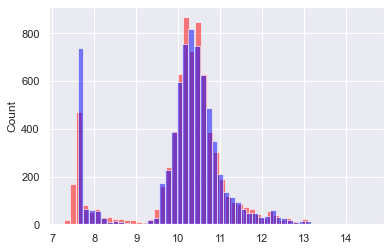

In [130]:
sns.histplot(y_hat, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [119]:
X_val = prepare_X(df_val, features, dv, fit=False)
y_hat = model2.predict(X_val)
df_metrics.loc['model2', 'rmse_val'] = sklearn.metrics.mean_squared_error(y_hat, y_val)

In [131]:
X_test = prepare_X(df_test, features, dv, fit=False)
y_hat = model2.predict(X_test)
df_metrics.loc['model2', 'rmse_test'] = sklearn.metrics.mean_squared_error(y_hat, y_test)

In [132]:
df_metrics

,rmse_train,rmse_val,rmse_test
base,0.540983,0.558099,NaN
model2,0.025818,0.185251,0.05282
